In [20]:
import numpy as np
from scipy.linalg import expm, sinm, cosm
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import math
from scipy.special import iv
from statsmodels.tsa.arima.model import ARIMA
import altair

In [16]:
def mets_filter(ts,rho,alpha):
    ts_mean = np.mean(ts)
    ts = np.append(ts,ts_mean)
    sample_size = len(ts)
    
    L_approx = np.zeros([sample_size, sample_size])

    for row in range(0,len(L_approx)-1):
        L_approx[row][row+1] =1

    L_approx[sample_size -1 ] = np.zeros(sample_size)
    filter_matrix = expm(rho*L_approx)
    
    output = np.dot(filter_matrix,ts) + alpha

    return output[:-1]


def ols_mets(ts, grid_size):
    sample_size = len(ts)
    L_approx = np.zeros([sample_size, sample_size])

    for row in range(0,len(L_approx)-1):
        L_approx[row][row+1] =1
    
    min_rho =  0.0
    filter_matrix = expm(min_rho*L_approx)
    resid = np.dot(filter_matrix,ts)
    min_alpha =  np.mean(resid)
    min_obj = np.square(np.std(resid))
    
    for rho in np.linspace(-2,2,grid_size):
        filter_matrix = expm(rho*L_approx)
        resid =  np.dot(filter_matrix,ts)
        alpha =  np.mean(resid)
        obj = np.square(np.std(resid))
        
        if obj < min_obj:
            min_alpha = alpha
            min_rho = rho
            min_obj = obj

    return [min_alpha, min_rho, min_obj]    

# Annual Data

In [3]:
m3_df = pd.read_excel( 'C:/Users/michelj8/Documents/GitHub/exp_smooth_lasso/m3_data.xls', sheet_name = 'M3Year')
m3_df.head()

,Series,N,NF,Category,Starting Year,Unnamed: 5,1,2,3,4,...,38,39,40,41,42,43,44,45,46,47
0,N 1,20,6,MICRO,1975,1,940.66,1084.86,1244.98,1445.02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,N 2,20,6,MICRO,1975,1,1991.05,2306.40,2604.00,2992.30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,N 3,20,6,MICRO,1975,1,1461.57,1692.50,2193.82,2459.68,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,N 4,20,6,MICRO,1975,1,744.54,1105.16,1417.40,1838.04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,N 5,20,6,MICRO,1975,1,4977.18,5248.00,5370.00,6184.89,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
ar_mse = []
mets_mse  = []
series_type = []

ar_coef = []
mets_coef = []

# for index in m3_df.index:
for index in range(0, 100):
    series_type.append( m3_df.loc[index,'Category'] )
    ts = m3_df.drop(columns = ['Series','N','NF','Category', 'Starting Year','Unnamed: 5']).loc[index].dropna()
    ts = ts.diff(1).dropna().values
    mets_model = ols_mets(ts, 50)
    mets_mse.append(mets_model[2] )
    mets_coef.append(-1*mets_model[1])
    
    ar_model = ARIMA(ts,order = (1,0,0)).fit()
    ar_mse.append(np.mean(np.square(ts- ar_model.predict())))
    ar_coef.append(ar_model.params[1])

C:\Users\michelj8\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


In [10]:
yearly_est_df = pd.DataFrame({'mets_mse':mets_mse, 
                              'ar_mse':ar_mse,
                              'series_type':series_type,
                             'ar_coef':ar_coef,
                             'mets_coef':mets_coef})
yearly_est_df.head()

,mets_mse,ar_mse,series_type,ar_coef,mets_coef
0,43810.073092,28149.950093,MICRO,0.756800,0.448980
1,393612.297666,393259.580755,MICRO,0.191862,0.204082
2,333659.054204,332617.127805,MICRO,0.337169,0.367347
3,367866.853314,368491.054723,MICRO,0.034072,0.040816
4,480823.548746,480701.033278,MICRO,0.017069,0.040816


# Quarterly

In [11]:
m3_df = pd.read_excel( 'C:/Users/michelj8/Documents/GitHub/exp_smooth_lasso/m3_data.xls', sheet_name = 'M3Quart')

ar_mse = []
mets_mse  = []
series_type = []

ar_coef = []
mets_coef = []

# for index in m3_df.index:
for index in range(0, 10):
    ts = m3_df.drop(columns = ['Series','N','NF','Category', 'Starting Year','Starting Quarter']).loc[index].dropna()
    series_type.append( m3_df.loc[index,'Category'] )
    ts = ts.diff(1).dropna().values
    mets_model = ols_mets(ts, 50)
    mets_mse.append(mets_model[2] )
    mets_coef.append(-1*mets_model[1])
    
    ar_model = ARIMA(ts,order = (1,0,0)).fit()
    ar_mse.append(np.mean(np.square(ts- ar_model.predict())))
    ar_coef.append(ar_model.params[1])
    

quarterly_est_df = pd.DataFrame({'mets_mse':mets_mse, 
                              'ar_mse':ar_mse,
                              'series_type':series_type,
                             'ar_coef':ar_coef,
                             'mets_coef':mets_coef})
quarterly_est_df.head()

,mets_mse,ar_mse,series_type,ar_coef,mets_coef
0,64264.409861,64217.156127,MICRO,0.027433,-0.000000
1,4630.309766,4561.081330,MICRO,-0.208103,-0.122449
2,23137.541167,23178.527449,MICRO,0.012556,0.040816
3,97532.764107,96721.799388,MICRO,-0.169962,-0.122449
4,15398.379995,13608.294347,MICRO,0.617972,0.530612


# Monthly

In [50]:
m3_df = pd.read_excel( 'C:/Users/michelj8/Documents/GitHub/exp_smooth_lasso/m3_data.xls', sheet_name = 'M3Month')

ar_mse = []
mets_mse  = []
series_type = []

ar_coef = []
mets_coef = []

# for index in m3_df.index:
for index in range(0, 50):
    ts = m3_df.drop(columns = ['Series','N','NF','Category', 'Starting Year','Starting Month']).loc[index].dropna()
    series_type.append( m3_df.loc[index,'Category'] )
    ts = np.log(ts).diff(1).dropna().values
    mets_model = ols_mets(ts, 50)
    mets_mse.append(mets_model[2] )
    mets_coef.append(-1*mets_model[1])
    
    ar_model = ARIMA(ts,order = (1,0,0)).fit()
    ar_mse.append(np.mean(np.square(ts- ar_model.predict())))
    ar_coef.append(ar_model.params[1])
    

monthly_est_df = pd.DataFrame({'mets_mse':mets_mse, 
                              'ar_mse':ar_mse,
                              'series_type':series_type,
                             'ar_coef':ar_coef,
                             'mets_coef':mets_coef})

monthly_est_df['MSE_Ratio'] =  100*(monthly_est_df['mets_mse']-monthly_est_df['ar_mse'])/monthly_est_df['ar_mse']
monthly_est_df.head()

,mets_mse,ar_mse,series_type,ar_coef,mets_coef,MSE_Ratio
0,0.504835,0.651061,MICRO,-0.518105,-1.020408,-22.459644
1,0.869515,0.975221,MICRO,-0.505090,-0.775510,-10.839131
2,0.241218,0.271305,MICRO,-0.515090,-0.775510,-11.089740
3,0.517072,0.626328,MICRO,-0.560277,-0.938776,-17.443952
4,0.296919,0.362953,MICRO,-0.529051,-0.938776,-18.193551


In [51]:
(altair.Chart(monthly_est_df, title = 'Monthly M3 Estimation')
 .mark_point()
 .encode(x=altair.X('ar_coef', title = 'AR(1) Coefficient'),
         y=altair.Y('mets_coef',title = 'METS Coefficient'),
         color=altair.Color('series_type', title = 'Series Type') )
)

alt.Chart(...)

In [52]:
altair.Chart(monthly_est_df).mark_bar().encode(
    altair.X("MSE_Ratio", bin=True),
    y='count()',
    color = altair.Color('series_type')
)

alt.Chart(...)

In [54]:
(altair.Chart(monthly_est_df, title = 'Monthly M3 Estimation')
 .mark_point()
 .encode(x=altair.X('mets_coef', title = 'METS Coefficient'),
         y=altair.Y('MSE_Ratio',title = 'Ratio of MSE'),
         color=altair.Color('series_type', title = 'Series Type') )
)

alt.Chart(...)

# Old code

In [92]:
len(error_df)

645

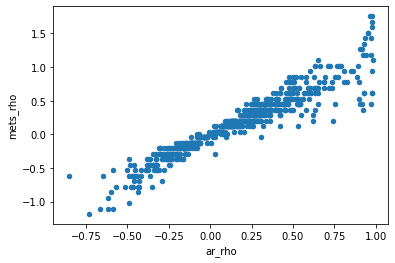

In [93]:
coef_df = pd.DataFrame({'mets_rho':mets_coef, 'ar_rho':ar_coef})
coef_df.plot.scatter(x='ar_rho',y='mets_rho')

In [91]:
len(error_df.query('mets_mse < ar_mse'))/len(error_df)

0.57984496124031

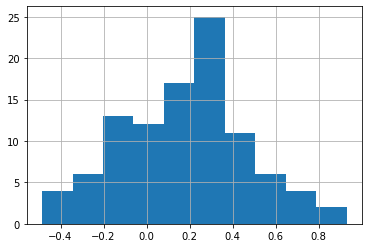

In [84]:
coef_df['ar_rho'].hist()

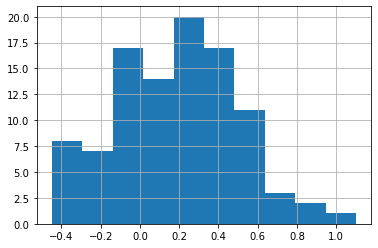

In [85]:
coef_df['mets_rho'].hist()

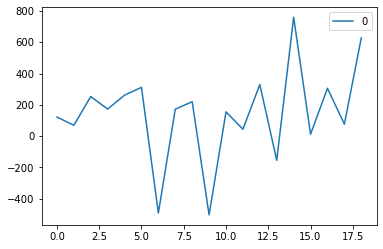

In [86]:
pd.DataFrame(ts).plot()

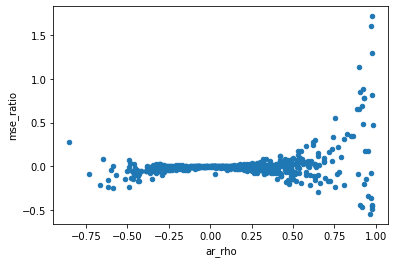

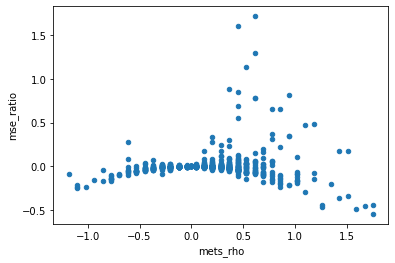

In [98]:
fitted_df = pd.DataFrame({'mets_rho':mets_coef, 'ar_rho':ar_coef,
                         'mets_mse':mets_mse, 'ar_mse':ar_mse})
fitted_df['mse_ratio'] = (fitted_df['mets_mse'] - fitted_df['ar_mse'])/fitted_df['ar_mse']
fitted_df.plot.scatter(x='ar_rho',y = 'mse_ratio')
fitted_df.plot.scatter(x='mets_rho',y = 'mse_ratio')